<a href="https://colab.research.google.com/github/fudw/dice_detection_for_board_games/blob/main/dice_detection_yolov5_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download dataset from https://public.roboflow.com/object-detection/dice/
!wget https://public.roboflow.com/ds/VdKh306UT4?key=4OgEXgYGDp
!unzip /content/VdKh306UT4?key=4OgEXgYGDp

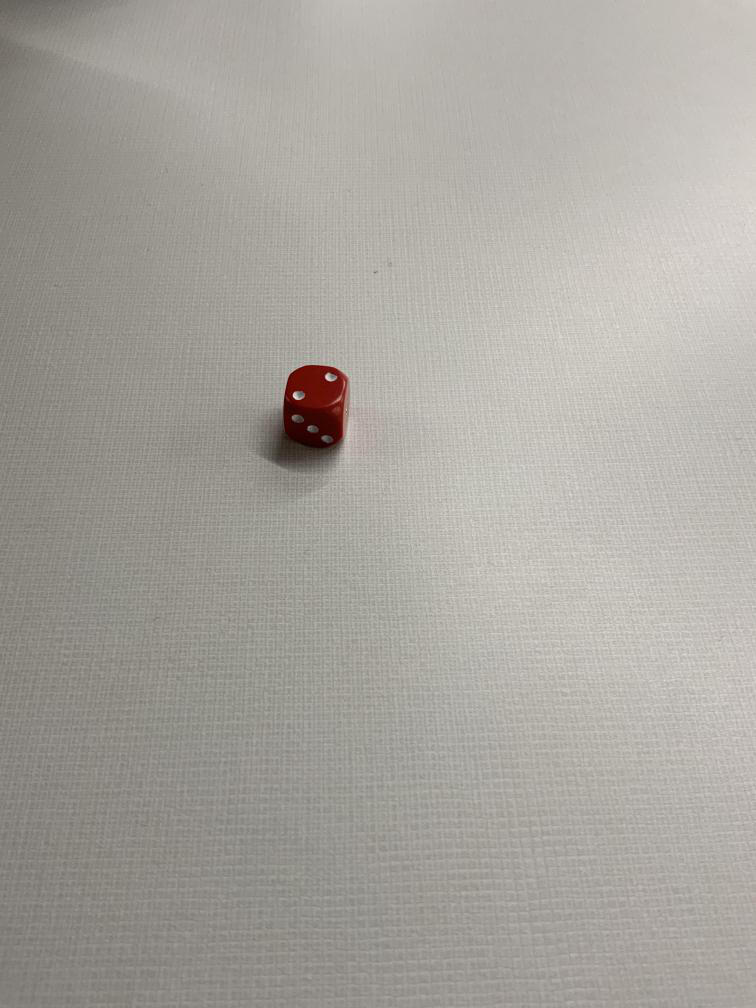

In [3]:
from PIL import Image

# take a look at an image
Image.open('/content/export/images/0BrzNN9qMnzQlQPZ1sso.jpg')

In [32]:
# import ALL the things
import os
import numpy as np
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms as T
import cv2
from matplotlib import pyplot as plt
import yaml

seed = 42
random.seed(seed)

In [5]:
os.listdir()

['.config',
 'README.dataset.txt',
 'export',
 'VdKh306UT4?key=4OgEXgYGDp',
 'data.yaml',
 'README.roboflow.txt',
 'sample_data']

In [9]:
os.rename('dice_dataset', 'export')

In [10]:
os.rename('export', 'dice_dataset')
root = os.path.abspath('dice_dataset')
image_dir = os.path.join(root, 'images')
label_dir = os.path.join(root, 'labels')

In [11]:
image_names = list(sorted(os.listdir(image_dir)))
label_names = list(sorted(os.listdir(label_dir)))

In [14]:
print(len(image_names))

718


In [15]:
train_val_split = 0.9
train_names = sorted(random.sample(image_names, int(len(image_names) * train_val_split)))
val_names = sorted(list(set(image_names) - set(train_names)))
print(f'training set has {len(train_names)} images')
print(f'validation set has {len(val_names)} images')

training set has 646 images
validation set has 72 images


In [17]:
print(image_names[0][:-4])

0BrzNN9qMnzQlQPZ1sso


In [18]:
label_file = os.path.join(label_dir, label_names[0])
with open(label_file, 'r') as file:
  targets = file.read()
targets = targets.split('\n')
targets

['1 0.4174933862433862 0.3835565476190476 0.08167989417989419 0.043402777777777776']

In [19]:
col = ['name', 'class', 'centre_x', 'centre_y', 'width', 'height']
image_df = pd.DataFrame(columns = col)
image_df

,name,class,centre_x,centre_y,width,height


In [20]:
row = {}
row[col[0]] = label_names[0][:-4]
for i, t in enumerate(targets[0].split(' ')):
  row[col[i+1]] = float(t)
row

{'centre_x': 0.4174933862433862,
 'centre_y': 0.3835565476190476,
 'class': 1.0,
 'height': 0.043402777777777776,
 'name': '0BrzNN9qMnzQlQPZ1sso',
 'width': 0.08167989417989419}

In [21]:
image_df.append(row, ignore_index = True)

,name,class,centre_x,centre_y,width,height
0,0BrzNN9qMnzQlQPZ1sso,1.0,0.417493,0.383557,0.08168,0.043403


In [22]:
image_df

,name,class,centre_x,centre_y,width,height


In [23]:
def get_targets(label_name):
  
  label_file = os.path.join(label_dir, label_name)
  with open(label_file, 'r') as file:
    targets = file.read()
  
  return targets.split('\n')

def get_row(label_name, targets, col):
  
  row = {}
  row[col[0]] = label_name[:-4]
  for i, t in enumerate(targets.split(' ')):
    row[col[i+1]] = float(t)
  
  return row

def add_targets_to_df(df, label_name):
  
  targets = get_targets(label_name)
  for target in targets:
    row = get_row(label_name, target, df.columns)
    df = df.append(row, ignore_index = True)
  
  return df

def create_image_df_with_labels(col, label_names):
  
  df = pd.DataFrame(columns = col)
  for name in label_names:
    df = add_targets_to_df(df, name)
  
  return df


In [24]:
final_df = create_image_df_with_labels(col, label_names)
final_df

,name,class,centre_x,centre_y,width,height
0,0BrzNN9qMnzQlQPZ1sso,1.0,0.417493,0.383557,0.081680,0.043403
1,0kpaB4UeoohBVODkOmGd,3.0,0.389385,0.640625,0.034061,0.023313
2,0kpaB4UeoohBVODkOmGd,5.0,0.675430,0.340278,0.024802,0.014385
3,0thII0LnXrzeDTZ6HbiS,3.0,0.528935,0.426711,0.081680,0.045387
4,1W3kCdCcSnq0jkQiZZ00,5.0,0.537822,0.501157,0.019593,0.029431
...,...,...,...,...,...,...
1929,zcDdJ83uFyJdnSy8ITcG,0.0,0.473380,0.667287,0.031415,0.020089
1930,zdYhuzHS1d5dtxnIkb5H,2.0,0.630622,0.483507,0.039683,0.031002
1931,zdYhuzHS1d5dtxnIkb5H,0.0,0.596726,0.384797,0.042659,0.031994
1932,zoYU94l6w95JmizBxoS7,1.0,0.661376,0.549355,0.042328,0.032242


In [25]:
def get_label_and_boxes(image_name, df):

  rows = df[df.name == image_name[:-4]]

  return rows['class'].values, rows[box_cols].values

In [26]:
box_cols = col[-4:]
box_cols

['centre_x', 'centre_y', 'width', 'height']

In [27]:
class dice_pretrain_dataset(torch.utils.data.Dataset):

  def __init__(self, root, image_names, df, transforms = None):

    super().__init__()
    self.root = root
    self.image_names = image_names
    self.df = df
    self.transforms = transforms

  def __len__(self):

    return len(self.image_names)

  def __getitem__(self, idx):

    image_name = self.image_names[idx]
    image_path = os.path.join(image_dir, image_name)
    img = Image.open(image_path).convert('RGB')

    target = {}
    labels, boxes = get_label_and_boxes(image_name, self.df)
    areas = boxes[:,2] * boxes[:, 3]
    iscrowd = torch.zeros((len(labels),))
    image_id = torch.tensor([idx])
    labels = torch.as_tensor(labels, dtype = torch.float32)
    boxes = torch.as_tensor(boxes, dtype = torch.float32)
    areas = torch.as_tensor(areas, dtype = torch.float32)
    target['boxes'] = boxes
    target['labels'] = labels
    target['areas'] = areas
    target['iscrowd'] = iscrowd
    target['image_id'] = image_id

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target
    

In [28]:
dice_dataset = dice_pretrain_dataset(root, image_names, final_df)

In [74]:
def draw_bbox(box, img_width, img_height, color = 'green'):

  rectangle = plt.Rectangle((img_width*box[0]-0.5*img_width*box[2], img_height*box[1]-0.5*img_height*box[3]), 
                            img_width*box[2], img_height*box[3], color = color, fill = False, lw = 3)
  return rectangle

def show_bboxes(img, bb):
  plt.figure(figsize = (14, 20))
  plt.imshow(img)
  boxes = np.array(bb, dtype = np.float32)
  print(boxes.shape)
  for box in list(boxes):
    plt.gca().add_patch(draw_bbox(box, img.width, img.height))

(2, 4)


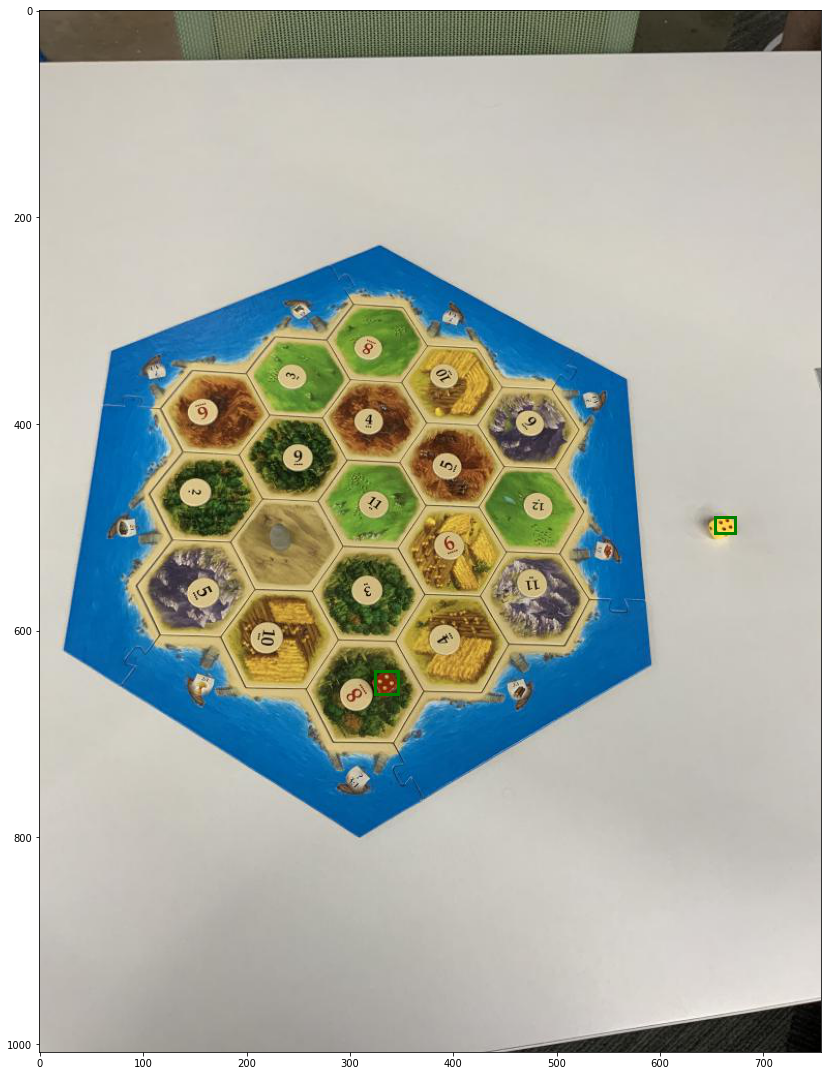

In [83]:
idx = 11
show_bboxes(dice_dataset[idx][0], dice_dataset[idx][1]['boxes'])

In [80]:
def get_transforms(istrain):
  transforms = []
  transforms.append(T.ToTensor())
  if istrain:
    transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.RandomVerticalFlip(0.5))
    transforms.append(T.RandomCrop(size = (512, 512)))

  return T.Compose(transforms)

In [81]:
train_dice_ds = dice_pretrain_dataset(root, image_names, final_df, get_transforms(True))
val_dice_ds = dice_pretrain_dataset(root, image_names, final_df, get_transforms(False))

In [ ]:
show_bboxes(val_dice_ds[1][0], val_dice_ds[1][1]['boxes'])